In [1]:
import torch
import pandas as pd
import numpy as np
from utils.GraphConvolution import GCN_Encoder_s, GCN_Classifier_s, Decoder_s
from utils.GraphConvolution import GraphConvolution, GCN_Encoder3
import argparse
import scipy.sparse as sp
import numpy as np
import torch
import ipdb
from tqdm.notebook import tqdm
from scipy.io import loadmat
import utils
from collections import defaultdict
from utils.GraphConvolution import GCN_Encoder3, GCN_Classifier, GCN_Encoder_w, sigmoid
import time
import torch.optim as optim
import torch.nn.functional as F
from utils.evaluation import accuracy, print_class_acc
import matplotlib.pyplot as plt
from visualization import confusion_matrix_vis
from sklearn.metrics import ConfusionMatrixDisplay


Initialization

In [2]:
class Args:
    weight_decay = 5e-4
    epochs = 1000
    learning_rate = 0.01
    learning_rate_W = 0.01
    dropout = 0.5
    dropout_W = 0.5
    gamma = 1
    no_cuda = False
    train_ratio=0.6
    test_ratio=0.2
    n_classes = 2
    seed = 1234
    torch.manual_seed(seed)
    # -----------------------
    dataset = "cora"
    # dataset = "haberman"
    # dataset = "diabetes"
    # dataset = "pubmed"
    # dataset = "citeseer"
    # -----------------------
    order = 4
    n_features = 0
    w_val_size = 10
    imbalance_ratio = None
    # imbalance_ratio = 0.05
    n_hidden = 64
    setting = None
    im_class_num = 1
    setting = "upsampling"
    opt_new_G = False
    up_scale = 1
    im_ratio = 0.5
    val_size = 10
    # -----------------------
    # momentum = 0 # For SGD
    momentum = 0
    # momentum = 0.5
    # momentum = 0.9
    # momentum = 0.95
    # -----------------------
    optimizer_alg = "ADAM"
    # optimizer_alg = "Momentum"
    # optimizer_alg = "RMSProp"
    # -----------------------
    # activation_func = "ReLU"
    # activation_func = "Sigmoid"
    activation_func = "LeakyReLU"
    # activation_func = "PReLU"
    # -----------------------
    initalization = "Xavier Uniform"
    # initalization = "Xavier Normal"
    # initalization = "Kaiming Uniform"
    # initalization = "Kaiming Normal"
    # initalization = "Uniform" # Uniform with 1 over squre root of the fan in 
    # -----------------------
    res_connection = False
    # res_connection = True
args = Args()


Dataset specific variables

In [8]:
from utils.data_loader import data_loader_diabetes, data_loader_haberman, data_loader_cora, data_loader

# cora_adj_mtx, cora_labels_df, cora_features_df, \
#         cora_train_idx, cora_val_idx, cora_test_idx, cora_n_features = data_loader_cora(args)
        
diabetes_adj_mtx, diabetes_labels_df, diabetes_features_df, \
        diabetes_train_idx, diabetes_val_idx, diabetes_test_idx, diabetes_n_features = data_loader_diabetes(args)

haberman_adj_mtx, haberman_labels_df, haberman_features_df, \
        haberman_train_idx, haberman_val_idx, haberman_test_idx, haberman_n_features = data_loader_haberman(args)

cora_adj_mtx, cora_labels_df, cora_features_df, \
        cora_train_idx, cora_val_idx, cora_test_idx, cora_n_features = data_loader(args, "cora", minoriy_classes = [2, 6])

pubmed_adj_mtx, pubmed_labels_df, pubmed_features_df, \
        pubmed_train_idx, pubmed_val_idx, pubmed_test_idx, pubmed_n_features = data_loader(args, "pubmed", minoriy_classes = [0])

citeseer_adj_mtx, citeseer_labels_df, citeseer_features_df, \
        citeseer_train_idx, citeseer_val_idx, citeseer_test_idx, citeseer_n_features = data_loader(args, "citeseer", minoriy_classes = [0])

if args.dataset == "diabetes":
    adj_mtx = diabetes_adj_mtx
    n_hidden = [64, 64, 64]
    n_features = diabetes_n_features
    features = diabetes_features_df
    labels = diabetes_labels_df
    # train_X = diabetes_train_X_df
    # train_Y = diabetes_train_Y_df
    # val_X = diabetes_val_X_df
    # val_Y = diabetes_val_Y_df
    # test_X = diabetes_test_X_df
    # test_Y = diabetes_test_Y_df
    train_idx = diabetes_train_idx
    val_idx = diabetes_val_idx
    test_idx = diabetes_test_idx
elif args.dataset == "cora":
    adj_mtx = cora_adj_mtx
    n_hidden = [64, 64, 64]
    n_features = cora_n_features
    features = cora_features_df
    labels = cora_labels_df
    # train_X = diabetes_train_X_df
    # train_Y = diabetes_train_Y_df
    # val_X = diabetes_val_X_df
    # val_Y = diabetes_val_Y_df
    # test_X = diabetes_test_X_df
    # test_Y = diabetes_test_Y_df
    train_idx = cora_train_idx
    val_idx = cora_val_idx
    test_idx = cora_test_idx
elif args.dataset == "pubmed":
    adj_mtx = pubmed_adj_mtx
    n_hidden = [64, 64]
    n_features = pubmed_n_features
    features = pubmed_features_df
    labels = pubmed_labels_df
    # train_X = diabetes_train_X_df
    # train_Y = diabetes_train_Y_df
    # val_X = diabetes_val_X_df
    # val_Y = diabetes_val_Y_df
    # test_X = diabetes_test_X_df
    # test_Y = diabetes_test_Y_df
    train_idx = pubmed_train_idx
    val_idx = pubmed_val_idx
    test_idx = pubmed_test_idx
elif args.dataset == "citeseer":
    adj_mtx = citeseer_adj_mtx
    n_hidden = [64, 64]
    n_features = citeseer_n_features
    features = citeseer_features_df
    labels = citeseer_labels_df
    # train_X = diabetes_train_X_df
    # train_Y = diabetes_train_Y_df
    # val_X = diabetes_val_X_df
    # val_Y = diabetes_val_Y_df
    # test_X = diabetes_test_X_df
    # test_Y = diabetes_test_Y_df
    train_idx = citeseer_train_idx
    val_idx = citeseer_val_idx
    test_idx = citeseer_test_idx
elif args.dataset == "haberman":
    adj_mtx = haberman_adj_mtx
    n_hidden = [64]
    n_features = haberman_n_features
    features = haberman_features_df
    labels = haberman_labels_df
    # train_X = haberman_train_X_df
    # train_Y = haberman_train_Y_df
    # val_X = haberman_val_X_df
    # val_Y = haberman_val_Y_df
    # test_X = haberman_test_X_df
    # test_Y = haberman_test_Y_df
    train_idx = haberman_train_idx
    val_idx = haberman_val_idx
    test_idx = haberman_test_idx
else:
    pass

KeyboardInterrupt: 

In [8]:
!pip install --no-index torch-scatter -f https://pytorch-geometric.com/whl/torch-1.13.0+cpu.html
!pip install --no-index torch-sparse -f https://pytorch-geometric.com/whl/torch-1.13.0+cpu.html
!pip install --no-index torch-cluster -f https://pytorch-geometric.com/whl/torch-1.13.0+cpu.html
!pip install --no-index torch-spline-conv -f https://pytorch-geometric.com/whl/torch-1.13.0+cpu.html
!pip install torch-geometric

Looking in links: https://pytorch-geometric.com/whl/torch-1.13.0+cpu.html
Looking in links: https://pytorch-geometric.com/whl/torch-1.13.0+cpu.html
Looking in links: https://pytorch-geometric.com/whl/torch-1.13.0+cpu.html
Looking in links: https://pytorch-geometric.com/whl/torch-1.13.0+cpu.html


In [206]:
# assert len(pd.DataFrame(labels[train_idx])[0].unique()) == len(pd.DataFrame(labels[val_idx])[0].unique()) == len(pd.DataFrame(labels[test_idx])[0].unique()), \
    # "There are some classes missing in one the 3 partitiones of the dataset"

In [207]:
device = torch.device("cuda" if False else "cpu")

Dataframe to Tensor transformation

In [208]:
# features = torch.from_numpy(np.concatenate((train_X, val_X, test_X), axis=0)).to(device)
# labels = torch.from_numpy(np.int64(np.concatenate((train_Y, val_Y, test_Y), axis=0))).to(device)
train_idx = torch.from_numpy(np.array(train_idx, dtype = np.int64)).to(device)
val_idx = torch.from_numpy(np.array(val_idx, dtype = np.int64)).to(device)
test_idx = torch.from_numpy(np.array(test_idx, dtype = np.int64)).to(device)
features = torch.from_numpy(np.array(features, dtype = np.float64)).to(device)
labels = torch.from_numpy(np.array(labels, dtype = np.int64)).to(device)
try:
    adj_mtx = torch.from_numpy(np.array(adj_mtx, dtype = np.float64)).to(device)
except:
    pass

Baseline 2 layer Classifier trainer

In [209]:
from utils.GraphConvolution import GCN_Encoder3, GCN_Classifier, GCN_Encoder_w
import time
import torch.optim as optim
import torch.nn.functional as F
from utils.evaluation import accuracy, print_class_acc

encoder_n = GCN_Encoder3(nfeat = n_features,
        nhid = n_hidden,
        nembed = n_hidden[-1],
        dropout = args.dropout,
        nclass = args.n_classes, 
        init = args.initalization,
        order = 1, 
        res_connection = args.res_connection)
classifier_n = GCN_Classifier(nembed = n_hidden[-1], 
        nhid = n_hidden[-1], 
        nclass = int(labels.max().item()) + 1, 
        dropout = args.dropout, init = args.initalization,
        device = device)

# encoder = GCN_Encoder_s(nfeat = n_features, nhid = n_hidden[-1], nembed = n_hidden[-1], dropout = args.dropout)
# classifier = GCN_Classifier_s(nembed = n_hidden[-1], nhid = n_hidden[-1], nclass = int(labels.max().item()) + 1, dropout = args.dropout, device = device)
# encoder_n = GCN_Encoder_w(nfeat = n_features, nembed = n_hidden[-1], nhid = n_hidden[-1], nclass = int(labels.max().item()) + 1, dropout = args.dropout, device = device)
# optimizer_n = optim.Adam(encoder_n.parameters(),
#                        lr = args.learning_rate, weight_decay = args.weight_decay)
if args.optimizer_alg == "ADAM":
        optimizer_en = optim.Adam(encoder_n.parameters(),
                        lr = args.learning_rate, weight_decay = args.weight_decay)
        optimizer_cls = optim.Adam(classifier_n.parameters(),
                        lr = args.learning_rate, weight_decay = args.weight_decay)
elif args.optimizer_alg == "Momentum":
        optimizer_en = optim.SGD(encoder_n.parameters(),
                        lr = args.learning_rate, momentum = args.momentum)
        optimizer_cls = optim.SGD(classifier_n.parameters(),
                        lr = args.learning_rate, momentum = args.momentum)
elif args.optimizer_alg == "RMSProp":
        optimizer_en = optim.SGD(encoder_n.parameters(),
                        lr = args.learning_rate, weight_decay = args.weight_decay)
        optimizer_cls = optim.SGD(classifier_n.parameters(),
                        lr = args.learning_rate, weight_decay = args.weight_decay)
else:
        optimizer_en = optim.Adam(encoder_n.parameters(),
                        lr = args.learning_rate, weight_decay = args.weight_decay)
        optimizer_cls = optim.Adam(classifier_n.parameters(),
                        lr = args.learning_rate, weight_decay = args.weight_decay)
def train(epoch):
        encoder_n.train()
        classifier_n.train()
        t = time.time()
        optimizer_en.zero_grad()
        optimizer_cls.zero_grad()
        # optimizer_n.zero_grad()
        embed = encoder_n(features, adj_mtx, funct = args.activation_func)
        output = classifier_n(embed, adj_mtx, funct = args.activation_func)
        # output = encoder_n(features, adj_mtx)
        out = output[train_idx]
        gt = labels[train_idx].reshape(-1)
        if args.setting == 'reweight':
                weight = "STH"
                loss_train = F.cross_entropy(out, gt, weight = weight)
        else:
                loss_train = F.cross_entropy(out, gt)
        acc_train = accuracy(out, gt)
        loss_train.backward()
        optimizer_en.step()
        optimizer_cls.step()
        # encoder_n.step()
        gt_v = labels[val_idx].reshape(-1)
        out_v = output[val_idx]
        loss_val = F.cross_entropy(out_v, gt_v)
        acc_val = accuracy(out_v, gt_v)
        # print_class_acc(out_v, gt_v)
        print('Epoch: {:05d}'.format(epoch + 1),
          'loss_train: {:.4f}'.format(loss_train.item()),
          'acc_train: {:.4f}'.format(acc_train.item()),
          'loss_val: {:.4f}'.format(loss_val.item()),
          'acc_val: {:.4f}'.format(acc_val.item()),
          'time: {:.4f}s'.format(time.time() - t))
        print_class_acc(output[val_idx], labels[val_idx])
        return acc_train.item(), acc_val.item(), loss_train.item(), loss_val.item()


In [210]:
import torch
torch.cuda.is_available()

True

Baseline 2 layer Classifier test

In [211]:
def test(epoch = 0):
    encoder_n.eval()
    classifier_n.eval()
#     outputs = encoder(features, adj_mtx)
    embed = encoder_n(features, adj_mtx, funct = args.activation_func)
    outputs = classifier_n(embed, adj_mtx, funct = args.activation_func)
    loss_test = F.cross_entropy(outputs[test_idx], labels[test_idx].reshape(-1))
    acc_test = accuracy(outputs[test_idx], labels[test_idx])
    print("Test set results:",
          "loss= {:.4f}".format(loss_test.item()),
          "accuracy= {:.4f}".format(acc_test.item()))
    print_class_acc(outputs[test_idx], labels[test_idx], pre='test')
    return loss_test.item(), acc_test.item(), outputs, embed

Baseline 2 layer Classifier training process

Epoch: 00001 loss_train: 35.0091 acc_train: 0.1810 loss_val: 20.5403 acc_val: 0.1624 time: 0.0242s
valid current auc-roc score: 0.536421, current macro_F score: 0.121022
Test set results: loss= 11.0258 accuracy= 964.3598
test current auc-roc score: 0.522391, current macro_F score: 0.101759
Epoch: 00002 loss_train: 41.0859 acc_train: 0.2439 loss_val: 14.6590 acc_val: 0.2343 time: 0.0233s
valid current auc-roc score: 0.553815, current macro_F score: 0.135918
Epoch: 00003 loss_train: 20.4833 acc_train: 0.2167 loss_val: 8.6922 acc_val: 0.2251 time: 0.0215s
valid current auc-roc score: 0.562283, current macro_F score: 0.145177
Epoch: 00004 loss_train: 11.3530 acc_train: 0.2804 loss_val: 5.4388 acc_val: 0.2897 time: 0.0211s
valid current auc-roc score: 0.619443, current macro_F score: 0.158935
Epoch: 00005 loss_train: 8.2221 acc_train: 0.3419 loss_val: 4.6193 acc_val: 0.2970 time: 0.0218s
valid current auc-roc score: 0.598333, current macro_F score: 0.166946
Epoch: 00006 loss_train: 7.4069 a

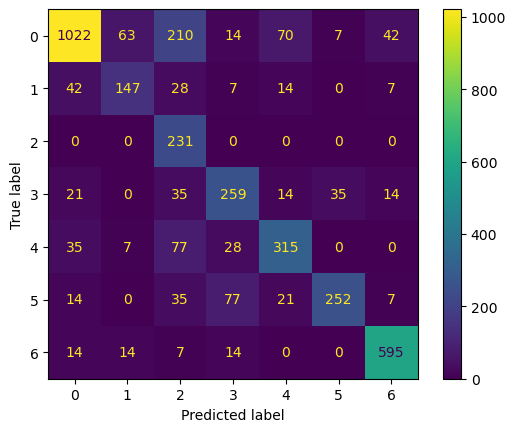

In [212]:
acc_trains = []
acc_vals = []
loss_trains = []
loss_vals = []
loss_test = []
test_acc = []
loss_tests = []
test_accs = []
outputs = None
embed = None

for epoch in range(args.epochs):
        acc_train, acc_val, loss_train, loss_val = train(epoch)
        acc_trains.append(acc_train)
        acc_vals.append(acc_val)
        loss_trains.append(loss_train)
        loss_vals.append(loss_val)
        if epoch % 10 == 0:
                loss_test, test_acc, outputs, embed = test(epoch)
                loss_tests.append(loss_test)
                test_accs.append(test_acc)
confusion_matrix_vis(outputs[test_idx], labels[test_idx])

In [213]:
embed.size()

torch.Size([2708, 64])

Save / Load Dictionary

In [214]:
import pickle

def save_dic(path, dictionary):
    with open(path, 'wb') as f:
        pickle.dump(dictionary, f)

def load_dic(path):
    with open(path, 'rb') as f:
        dic = pickle.load(f)
    return dic

Save Result

In [215]:
result = {
    "acc_trains": acc_trains,
    "acc_vals": acc_vals,
    "loss_trains": loss_trains,
    "loss_vals": loss_vals,
    "loss_test": loss_test,
    "test_acc": test_acc,
    "loss_tests": loss_tests,
    "test_accs": test_accs
}
save_dic('result.pkl', result)

Saving the trained 2 layer classifier model

In [216]:
def save_model():
    saved_content = {}
    saved_content['encoder'] = encoder_n.state_dict()
    saved_content['classifier'] = classifier_n.state_dict()
    torch.save(saved_content, 'checkpoint/{}/Normal_opt{}_m{}_act{}_init{}_ir{}_res{}_l{}_h{}.pth'.format(args.dataset, 
    args.optimizer_alg, 
    args.momentum, 
    args.activation_func, 
    args.initalization,
    args.imbalance_ratio,
    args.res_connection,
    len(n_hidden),
    n_hidden[-1]))
    return
save_model()

GraphSMOTE's trainer

In [217]:
from copy import deepcopy

encoder_s = GCN_Encoder_s(nfeat = features.shape[1],
        nhid = args.n_hidden,
        nembed = args.n_hidden,
        dropout = args.dropout, init = args.initalization)
classifier_s = GCN_Classifier_s(nembed=args.n_hidden, 
        nhid = args.n_hidden, 
        nclass = labels.max().item() + 1, 
        dropout = args.dropout, device = device, init = args.initalization)
decoder_s = Decoder_s(nembed = args.n_hidden,
        dropout = args.dropout, init = args.initalization)
# optimizer_en = optim.Adam(encoder_s.parameters(),
#                        lr=args.learning_rate, weight_decay=args.weight_decay)
# optimizer_cls = optim.Adam(classifier_s.parameters(),
#                        lr=args.learning_rate, weight_decay=args.weight_decay)
# optimizer_de = optim.Adam(decoder_s.parameters(),
#                        lr=args.learning_rate, weight_decay=args.weight_decay)
if args.optimizer_alg == "ADAM":
        optimizer_en = optim.Adam(encoder_n.parameters(),
                        lr = args.learning_rate, weight_decay = args.weight_decay)
        optimizer_cls = optim.Adam(classifier_n.parameters(),
                        lr = args.learning_rate, weight_decay = args.weight_decay)
        optimizer_de = optim.Adam(decoder_s.parameters(),
                       lr = args.learning_rate, weight_decay = args.weight_decay)
elif args.optimizer_alg == "Momentum":
        optimizer_en = optim.SGD(encoder_n.parameters(),
                        lr = args.learning_rate, momentum = args.momentum)
        optimizer_cls = optim.SGD(classifier_n.parameters(),
                        lr = args.learning_rate, momentum = args.momentum)
        optimizer_de = optim.SGD(decoder_s.parameters(),
                        lr = args.learning_rate, momentum = args.momentum)
elif args.optimizer_alg == "RMSProp":
        optimizer_en = optim.RMSprop(encoder_n.parameters(),
                        lr = args.learning_rate, weight_decay = args.weight_decay)
        optimizer_cls = optim.RMSprop(classifier_n.parameters(),
                        lr = args.learning_rate, weight_decay = args.weight_decay)
        optimizer_de = optim.RMSprop(decoder_s.parameters(),
                        lr = args.learning_rate, weight_decay = args.weight_decay)
else:
        optimizer_en = optim.Adam(encoder_n.parameters(),
                        lr = args.learning_rate, weight_decay = args.weight_decay)
        optimizer_cls = optim.Adam(classifier_n.parameters(),
                        lr = args.learning_rate, weight_decay = args.weight_decay)
        optimizer_de = optim.Adam(decoder_s.parameters(),
                        lr = args.learning_rate, weight_decay = args.weight_decay)
def train(epoch):
    t = time.time()
    encoder_s.train()
    classifier_s.train()
    decoder_s.train()
    optimizer_en.zero_grad()
    optimizer_cls.zero_grad()
    optimizer_de.zero_grad()

    embed = encoder_s(features, adj_mtx)

    if args.setting == 'recon_newG' or args.setting == 'recon' or args.setting == 'newG_cls':
        ori_num = labels.shape[0]
        embed, labels_new, idx_train_new, adj_up = utils.recon_upsample(embed, labels, train_idx, adj = adj_mtx.detach().to_dense(), portion = args.up_scale, im_class_num = args.im_class_num)
        generated_G = decoder_s(embed)

        loss_rec = utils.adj_mse_loss(generated_G[: ori_num, :][:, : ori_num], adj_mtx.detach().to_dense())
        
        #ipdb.set_trace()


        if not args.opt_new_G:
            adj_new = copy.deepcopy(generated_G.detach())
            threshold = 0.5
            adj_new[adj_new < threshold] = 0.0
            adj_new[adj_new >= threshold] = 1.0

            #ipdb.set_trace()
            edge_ac = adj_new[: ori_num, : ori_num].eq(adj_mtx.to_dense()).double().sum()/(ori_num**2)
        else:
            adj_new = generated_G
            edge_ac = F.l1_loss(adj_new[: ori_num, : ori_num], adj_mtx.to_dense(), reduction = 'mean')


        #calculate generation information
        exist_edge_prob = adj_new[:ori_num, :ori_num].mean() #edge prob for existing nodes
        generated_edge_prob = adj_new[ori_num:, :ori_num].mean() #edge prob for generated nodes
        print("edge acc: {:.4f}, exist_edge_prob: {:.4f}, generated_edge_prob: {:.4f}".format(edge_ac.item(), exist_edge_prob.item(), generated_edge_prob.item()))


        adj_new = torch.mul(adj_up, adj_new)

        exist_edge_prob = adj_new[:ori_num, :ori_num].mean() #edge prob for existing nodes
        generated_edge_prob = adj_new[ori_num:, :ori_num].mean() #edge prob for generated nodes
        print("after filtering, edge acc: {:.4f}, exist_edge_prob: {:.4f}, generated_edge_prob: {:.4f}".format(edge_ac.item(), exist_edge_prob.item(), generated_edge_prob.item()))


        adj_new[:ori_num, :][:, :ori_num] = adj_mtx.detach().to_dense()
        #adj_new = adj_new.to_sparse()
        #ipdb.set_trace()

        if not args.opt_new_G:
            adj_new = adj_new.detach()

        if args.setting == 'newG_cls':
            idx_train_new = train_idx

    elif args.setting == 'embed_up':
        #perform SMOTE in embedding space
        embed, labels_new, idx_train_new = utils.recon_upsample(embed, labels, train_idx, portion=args.up_scale, im_class_num = args.im_class_num)
        adj_new = adj_mtx
    else:
        labels_new = labels
        idx_train_new = train_idx
        adj_new = adj_mtx

    #ipdb.set_trace()
    output = classifier_s(embed, adj_new)



    if args.setting == 'reweight':
        weight = features.new((labels.max().item() + 1)).fill_(1)
        weight[-args.im_class_num:] = 1 + args.up_scale
        loss_train = F.cross_entropy(output[idx_train_new], labels_new[idx_train_new].reshape(-1), weight=weight)
    else:
        loss_train = F.cross_entropy(output[idx_train_new], labels_new[idx_train_new].reshape(-1))

    acc_train = accuracy(output[train_idx], labels_new[train_idx].reshape(-1))
    if args.setting == 'recon_newG':
        loss = loss_train + loss_rec * args.rec_weight
    elif args.setting == 'recon':
        loss = loss_rec + 0 * loss_train
    else:
        loss = loss_train
        loss_rec = loss_train

    loss.backward()
    if args.setting == 'newG_cls':
        optimizer_en.zero_grad()
        optimizer_de.zero_grad()
    else:
        optimizer_en.step()

    optimizer_cls.step()

    if args.setting == 'recon_newG' or args.setting == 'recon':
        optimizer_de.step()

    loss_val = F.cross_entropy(output[val_idx], labels[val_idx].reshape(-1))
    acc_val = accuracy(output[val_idx], labels[val_idx].reshape(-1))

    print('Epoch: {:05d}'.format(epoch + 1),
          'loss_train: {:.4f}'.format(loss_train.item()),
          'loss_rec: {:.4f}'.format(loss_rec.item()),
          'acc_train: {:.4f}'.format(acc_train.item()),
          'loss_val: {:.4f}'.format(loss_val.item()),
          'acc_val: {:.4f}'.format(acc_val.item()),
          'time: {:.4f}s'.format(time.time() - t))
    return acc_train.item(), acc_val.item(), loss_train.item(), loss_val.item()

GraphSOMTE's test

In [218]:
def test(epoch = 0):
    encoder_s.eval()
    classifier_s.eval()
#     outputs = encoder(features, adj_mtx)
    embed = encoder_s(features, adj_mtx)
    outputs = classifier_s(embed, adj_mtx)
    loss_test = F.cross_entropy(outputs[test_idx], labels[test_idx])
    acc_test = accuracy(outputs[test_idx], labels[test_idx])
    print("Test set results:",
          "loss= {:.4f}".format(loss_test.item()),
          "accuracy= {:.4f}".format(acc_test.item()))
    print_class_acc(outputs[test_idx], labels[test_idx], pre='test')
    return loss_test.item(), acc_test.item(), outputs

GraphSOMTE's training process

In [219]:
acc_trains = []
acc_vals = []
loss_trains = []
loss_vals = []
loss_test = []
test_acc = []
loss_tests = []
test_accs = []

for epoch in tqdm(range(args.epochs)):
        acc_train, acc_val, loss_train, loss_val = train(epoch, features, labels)
        acc_trains.append(acc_train)
        acc_vals.append(acc_val)
        loss_trains.append(loss_train)
        loss_vals.append(loss_val)
        if epoch % 10 == 0:
                test(epoch)
                loss_test, test_acc, outputs = test(epoch)
                loss_tests.append(loss_test)
                test_accs.append(test_acc)
confusion_matrix_vis(outputs[test_idx], labels[test_idx])

ImportError: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html

Saving the trained GraphSMOTE's model

In [ ]:
def save_model():
    saved_content = {}
    saved_content['encoder'] = encoder_s.state_dict()
    saved_content['classifier'] = classifier_s.state_dict()
    saved_content['decoder'] = decoder_s.state_dict()
    torch.save(saved_content, 'checkpoint/{}/GraphSMOTE_opt{}_m{}_act{}_init{}_ir{}_res{}_l{}_h{}.pth'.format(args.dataset, 
        args.optimizer_alg, 
        args.momentum, 
        args.activation_func, 
        args.initalization,
        args.imbalance_ratio,
        args.res_connection,
        len(n_hidden),
        n_hidden[-1]))
        return
save_model()

Reweight model's train

In [ ]:
from utils.GraphConvolution import GCN_Encoder3, GCN_Classifier, GCN_Encoder_w
import time
import torch.optim as optim
import torch.nn.functional as F
from utils.evaluation import accuracy, print_class_acc
import torch
from tqdm.notebook import tqdm
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torchvision import datasets,transforms
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader
import time
import copy
import torch.nn.functional as F
import copy
from torch import autograd
import higher
import itertools
from utils.reweight import next, next2
import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter("ignore")
np.seterr(all="ignore")


# encoder = GCN_Encoder3(nfeat=n_features,
#         nhid=n_hidden,
#         nembed=n_hidden[-1],
#         dropout=args.dropout,
#         nclass=args.n_classes,
#         order=1)
# classifier = GCN_Classifier(nembed=n_hidden[-1], 
#         nhid=n_hidden[-1], 
#         nclass=int(labels.max().item()) + 1, 
#         dropout=args.dropout, device=device)
encoder = GCN_Encoder_w(nfeat = n_features, 
        nembed = n_hidden[-1], 
        nhid = n_hidden[-1], 
        nclass = int(labels.max().item()) + 1, 
        dropout = args.dropout, 
        device = device, init = args.initalization)
# optimizer = optim.Adam(encoder.parameters(),
#                        lr = args.learning_rate, weight_decay = args.weight_decay)
if args.optimizer_alg == "ADAM":
        optimizer = optim.Adam(encoder_n.parameters(),
                        lr = args.learning_rate, weight_decay = args.weight_decay)
elif args.optimizer_alg == "Momentum":
        optimizer = optim.SGD(encoder_n.parameters(),
                        lr = args.learning_rate, momentum = args.momentum)
elif args.optimizer_alg == "RMSProp":
        optimizer = optim.SGD(encoder_n.parameters(),
                        lr = args.learning_rate, weight_decay = args.weight_decay)
else:
        optimizer = optim.Adam(encoder_n.parameters(),
                        lr = args.learning_rate, weight_decay = args.weight_decay)
# criterion = nn.BCEWithLogitsLoss().to(device)
def train(epoch, features, labels):
        encoder.train()
        # classifier.train()
        t = time.time()
        optimizer.zero_grad()
        with higher.innerloop_ctx(encoder, optimizer) as (meta_model, meta_opt):
                meta_train_outputs = meta_model(features, adj_mtx)
                # criterion.reduction = 'none'
                # new_labels = F.one_hot(labels, num_classes=int(labels.max().item()) + 1).double()
                meta_train_loss = F.cross_entropy(meta_train_outputs[train_idx], labels[train_idx])
                # meta_train_loss = criterion(meta_train_outputs[train_idx], new_labels[train_idx])
                eps = torch.zeros(meta_train_loss.size(), requires_grad=True, device=device)
                meta_train_loss = torch.sum(eps * meta_train_loss)
                meta_opt.step(meta_train_loss)
                sampled_val_idx, new_adj_mtx, new_features, new_labels = next(args, features, labels, val_idx, adj_mtx)
                # meta_inputs, meta_labels = next(args, features, labels, val_idx, adj_mtx)
                meta_val_idx, meta_adj_mtx, meta_features, meta_labels = sampled_val_idx.to(device=device, non_blocking=True), \
                        new_adj_mtx.to(device=device, non_blocking=True), \
                        new_features.to(device=device, non_blocking=True), \
                        new_labels.to(device=device, non_blocking=True)
                meta_val_outputs = meta_model(meta_features, meta_adj_mtx.double())
                # criterion.reduction = 'mean'
                # new_meta_labels = F.one_hot(meta_labels, num_classes=int(labels.max().item()) + 1).double()
                meta_train_loss = F.cross_entropy(meta_val_outputs, meta_labels)
                # meta_val_loss = criterion(meta_val_outputs, new_meta_labels)
                eps_grads = torch.autograd.grad(meta_train_loss, eps)[0].detach()
        w_tilde = torch.clamp(-eps_grads, min=0)
        l1_norm = torch.sum(w_tilde)
        if l1_norm != 0:
                w = w_tilde / l1_norm
        else:
                w = w_tilde
        outputs = encoder(features, adj_mtx.double())
        # criterion.reduction = 'none'
        # new_main_labels = F.one_hot(labels, num_classes=int(labels.max().item()) + 1).double()
        loss = F.cross_entropy(outputs[train_idx], labels[train_idx])
        # loss = criterion(outputs[train_idx], new_main_labels[train_idx])
        loss = torch.sum(w * loss)

        loss_train = F.cross_entropy(outputs[train_idx], labels[train_idx].reshape(-1))
        acc_train = accuracy(outputs[train_idx], labels[train_idx].reshape(-1))

        loss.backward()
        optimizer.step()

        loss_val = F.cross_entropy(outputs[val_idx], labels[val_idx].reshape(-1))
        acc_val = accuracy(outputs[val_idx], labels[val_idx].reshape(-1))

        print('Epoch: {:05d}'.format(epoch + 1),
                'loss_train: {:.4f}'.format(loss_train.item()),
                'acc_train: {:.4f}'.format(acc_train.item()),
                'loss_val: {:.4f}'.format(loss_val.item()),
                'acc_val: {:.4f}'.format(acc_val.item()),
                'time: {:.4f}s'.format(time.time() - t))
        return acc_train.item(), acc_val.item(), loss_train.item(), loss_val.item()

        # keep track of epoch loss/accuracy
        # train_loss += loss.item() * outputs.shape[0]

                # out = output[train_idx]
                # gt = labels[train_idx].reshape(-1)
                # if args.setting == 'reweight':
                #         weight = "STH"
                #         loss_train = F.cross_entropy(out, gt, weight = weight)
                # else:
                #         loss_train = F.cross_entropy(out, gt)
                # acc_train = accuracy(out, gt)
                # loss_train.backward()
                # optimizer_en.step()
                # optimizer_cls.step()
                # gt_v = labels[test_idx].reshape(-1)
                # out_v = output[test_idx]
                # loss_val = F.cross_entropy(out_v, gt_v)
                # acc_val = accuracy(out_v, gt_v)
                # # print_class_acc(out_v, gt_v)
                # print('Epoch: {:05d}'.format(epoch+ 1),
                # 'loss_train: {:.4f}'.format(loss_train.item()),
                # 'acc_train: {:.4f}'.format(acc_train.item()),
                # 'loss_val: {:.4f}'.format(loss_val.item()),
                # 'acc_val: {:.4f}'.format(acc_val.item()),
                # 'time: {:.4f}s'.format(time.time() - t))
                
        # return acc_train.item(), acc_val.item(), loss_train.item(), loss_val.item()


Reweight model's test

In [ ]:
def test(epoch = 0):
    encoder.eval()
    outputs = encoder(features, adj_mtx)
    loss_test = F.cross_entropy(outputs[test_idx], labels[test_idx])
    acc_test = accuracy(outputs[test_idx], labels[test_idx])
    print("Test set results:",
          "loss= {:.4f}".format(loss_test.item()),
          "accuracy= {:.4f}".format(acc_test.item()))

    print_class_acc(outputs[test_idx], labels[test_idx], pre='test')
    return loss_test.item(), acc_test.item(), outputs

Reweight model's train and testing process

In [ ]:
acc_trains = []
acc_vals = []
loss_trains = []
loss_vals = []
loss_test = []
test_acc = []
loss_tests = []
test_accs = []
for epoch in tqdm(range(args.epochs)):
        acc_train, acc_val, loss_train, loss_val = train(epoch, features, labels)
        acc_trains.append(acc_train)
        acc_vals.append(acc_val)
        loss_trains.append(loss_train)
        loss_vals.append(loss_val)
        if epoch % 10 == 0:
                loss_test, test_acc, outputs = test(epoch)
                loss_tests.append(loss_test)
                test_accs.append(test_acc)
confusion_matrix_vis(outputs[test_idx], labels[test_idx])

Saving the reweight model

In [ ]:
def save_model():
    saved_content = {}
    saved_content['encoder'] = encoder.state_dict()
    torch.save(saved_content, 'checkpoint/{}/Reweight_opt{}_m{}_act{}_init{}_ir{}_res{}_l{}_h{}.pth'.format(args.dataset, 
        args.optimizer_alg, 
        args.momentum, 
        args.activation_func, 
        args.initalization,
        args.imbalance_ratio,
        args.res_connection,
        len(n_hidden),
        n_hidden[-1]))
    return
save_model()

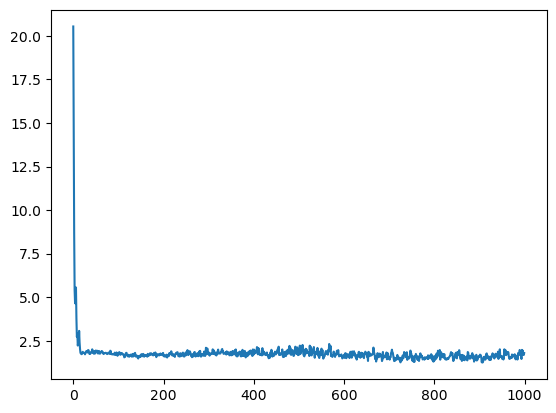

In [ ]:
%matplotlib inline
from matplotlib import pyplot as plt

# %matplotlib notebook
# %matplotlib inline

plt.plot(loss_vals)

plt.show()

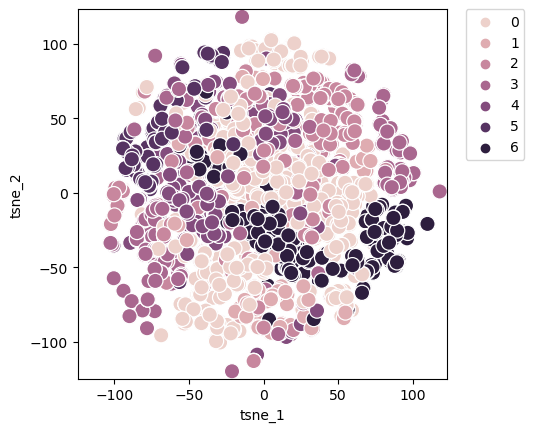

In [220]:
import numpy as np
from sklearn.manifold import TSNE
import pandas as pd
import seaborn as sns

X = embed.cpu().detach().numpy()
y = labels.cpu().detach().numpy().reshape(-1)
X_embedded = TSNE(n_components=2, learning_rate='auto',
                  init='random', perplexity=3).fit_transform(X)
X_embedded.shape


tsne_result_df = pd.DataFrame({'tsne_1': X_embedded[:,0], 'tsne_2': X_embedded[:,1], 'label': y})
fig, ax = plt.subplots(1)
sns.scatterplot(x='tsne_1', y='tsne_2', hue='label', data=tsne_result_df, ax=ax,s=120)
lim = (X_embedded.min()-5, X_embedded.max()+5)
ax.set_xlim(lim)
ax.set_ylim(lim)
ax.set_aspect('equal')
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)
 

In [221]:
import json
  
# Opening JSON file
f = open('./data/dataset_pubmed.json')
data = json.load(f)

df = pd.DataFrame(data['rows'])
df


,row_idx,row,truncated_cells
0,0,"{'MedlineCitation': {'PMID': 1, 'DateCompleted...",[]
1,1,"{'MedlineCitation': {'PMID': 2, 'DateCompleted...",[]
2,2,"{'MedlineCitation': {'PMID': 3, 'DateCompleted...",[]
3,3,"{'MedlineCitation': {'PMID': 4, 'DateCompleted...",[]
4,4,"{'MedlineCitation': {'PMID': 5, 'DateCompleted...",[]
...,...,...,...
95,95,"{'MedlineCitation': {'PMID': 95, 'DateComplete...",[]
96,96,"{'MedlineCitation': {'PMID': 97, 'DateComplete...",[]
97,97,"{'MedlineCitation': {'PMID': 98, 'DateComplete...",[]
98,98,"{'MedlineCitation': {'PMID': 99, 'DateComplete...",[]
